In [2]:
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
from src.data.datasets import ModelParamsDataset
import wandb
from src.config import config as cfg

from src.data.helpers import rotate, get_accuracy, model_to_list, list_to_model, get_moons_dataset
from src.visualization.visualize import plot_decision_boundary

from src.model.models import MLP

import pandas as pd
import numpy as np

## Autoencoder

In [655]:
class Autoencoder(torch.nn.Module):
    def __init__(self) -> None:
        super(Autoencoder, self).__init__()
        
        self.encoder = self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
        )

        self.decoder = self.decoder = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 33),
        )
    
    def reparameterize(self, mean, log_var):
        var = torch.exp(0.5*log_var)
        epsilon = torch.randn_like(var)     
        latent = mean + var*epsilon
        return latent

    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output


config = {
    "model":{
        "name": "Autoencoder small",
        "layers": [33, 512, 256, 64, 16, 10]
    },
    "hyperparameters":{
        "epochs": 100,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam"
    }
}

dataset = ModelParamsDataset("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

# wandb_config = cfg.load_env()
# run = wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="autoencoder_small")

torch.manual_seed(0)
autoencoder = Autoencoder()
autoencoder.to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = learning_rate, weight_decay=weight_decay)

for epoch in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        pred = autoencoder(X)
        loss = loss_function(pred, X)
        # disentangle latent space
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # wandb.log({"loss": loss.item()})
    if(epoch % 5 == 0):
        print(f"Epoch {epoch+1}: Loss: {loss.item()}")
        torch.save(autoencoder.state_dict(), f"../models/autoencoders/autoencoder_{epoch}.pth")

# wandb.alert(title="Autoencoder training finished", text=f"Loss: {loss.item()}")
# model_path = "../models/autoencoder_candidate.pth"
# torch.save(model.state_dict(), model_path)
# model_artifact = wandb.Artifact(f"autoencoder", type="model")
# model_artifact.add_file(model_path)
# run.log_artifact(model_artifact)
# wandb.finish()

# m = MLP(2, [8], 1)
# weights, angle = dataset[22311]
# list_to_model(m, weights.tolist())
# X, y = get_moons_dataset(1000, 0.1)
# plot_decision_boundary(m, X, y)

# model.to("cpu")
# model.eval()
# with torch.no_grad():
#     out = model(weights)
#     list_to_model(m, out.tolist())
#     plot_decision_boundary(m, X, y) 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Loss: 1.2302196025848389
Epoch 6: Loss: 0.13492940366268158
Epoch 11: Loss: 0.07018839567899704
Epoch 16: Loss: 0.04918954148888588
Epoch 21: Loss: 0.04235966503620148
Epoch 26: Loss: 0.03458479046821594
Epoch 31: Loss: 0.03248152509331703
Epoch 36: Loss: 0.025375070050358772
Epoch 41: Loss: 0.021962452679872513
Epoch 46: Loss: 0.025069693103432655
Epoch 51: Loss: 0.019173894077539444
Epoch 56: Loss: 0.012001625262200832
Epoch 61: Loss: 0.011849568225443363
Epoch 66: Loss: 0.012688557617366314
Epoch 71: Loss: 0.009128998965024948
Epoch 76: Loss: 0.00856658536940813
Epoch 81: Loss: 0.009559743106365204
Epoch 86: Loss: 0.011108526028692722
Epoch 91: Loss: 0.010200194083154202
Epoch 96: Loss: 0.00895479042083025


In [638]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

data_raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data_raw[:, -1]
data = data_raw[:, 1:-1]

(80000, 128)
(80000, 3)


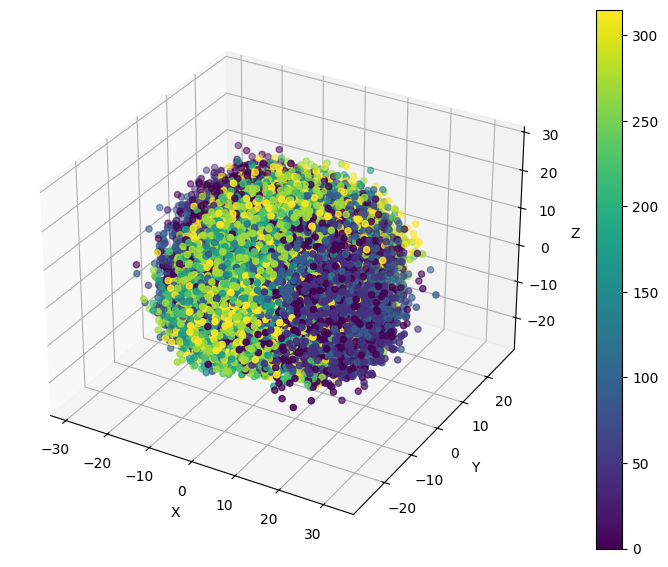

In [675]:
index = 0
autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_{index}.pth"))
autoencoder.eval()
autoencoder.to("cpu")
latent = autoencoder.encoder(torch.tensor(data).float()).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(0, 0, 90)

plt.show()

90.0 135.0


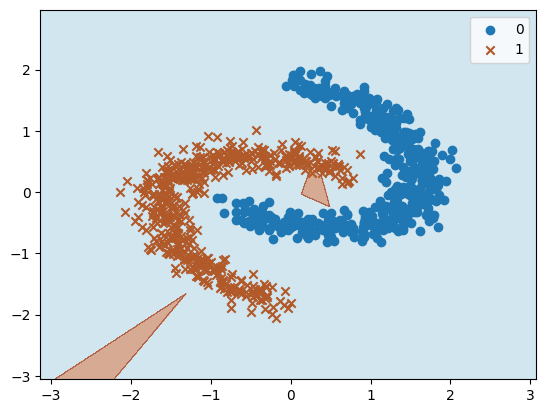

In [674]:
X, y = get_moons_dataset(1000, 0.1)
model = MLP(2, [8], 1)

index1 = 72023
index2 = 11002

angle1 = angles[index1]
angle2 = angles[index2]
print(angle1, angle2)
weights1 = torch.tensor(data[index1]).float()
weights2 = torch.tensor(data[index2]).float()

latent_1 = autoencoder.encoder(weights1.unsqueeze(0))
latent_2 = autoencoder.encoder(weights2.unsqueeze(0))

alpha = 0.5
latent = (1-alpha)*latent_1 + alpha*latent_2
angle = (1-alpha)*angle1 + alpha*angle2


output = autoencoder.decoder(latent)

X_rotated = rotate(X, angle)
list_to_model(model, output[0].tolist())
plot_decision_boundary(model, X_rotated, y)

## Variational Autoencoder to generate weights

In [86]:
class Variational(torch.nn.Module):
    def __init__(self) -> None:
        super(Variational, self).__init__()
        
        self.encoder = self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 10),
        )

        self.decoder = self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 33),
        )

        self.mean = torch.nn.Linear(10, 10)
        self.log_var = torch.nn.Linear(10, 10)
    
    def reparameterize(self, mean, log_var):
        var = torch.exp(0.5*log_var)
        epsilon = torch.randn_like(var)     
        latent = mean + var*epsilon
        return latent

    def forward(self, x):
        latent = self.encoder(x)
        mean = self.mean(latent)
        log_var = self.log_var(latent)
        x = self.reparameterize(mean, log_var)
        output = self.decoder(x)
        return output, mean, log_var


config = {
    "model":{
        "name": "Variational Autoencoder",
        "layers": [33, 512, 256, 64, 16, 10]
    },
    "hyperparameters":{
        "epochs": 100,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam"
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

wandb_config = cfg.load_env()
run = wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="variational_autoencoder")
torch.manual_seed(42)

variational = Variational()
variational.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(variational.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda:0")

dataset = ModelParamsDataset("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


for i in tqdm(range(epochs)):
    for X, y in dataloader:
        X = X.to(device)
        output, mean, log_var = variational(X)

        loss = loss_fn(output, X)
        kl_div = -0.5*torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        loss += (6.105925e-3 * kl_div)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    wandb.log({"loss": loss.item()})
    print(f'Epoch: {i+1}, Loss: {loss.item()}')


model_path = "../models/variational_autoencoder.pth"
torch.save(variational.state_dict(), model_path)

model_artifact = wandb.Artifact("variational_autoencoder", type="model")
model_artifact.add_file(model_path)
run.log_artifact(model_artifact)
wandb.finish()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Loss: 4.948981761932373
Epoch: 2, Loss: 4.942610263824463
Epoch: 3, Loss: 4.954706192016602
Epoch: 4, Loss: 4.958126544952393
Epoch: 5, Loss: 4.690866470336914
Epoch: 6, Loss: 4.773575782775879
Epoch: 7, Loss: 4.960766792297363
Epoch: 8, Loss: 4.6440582275390625
Epoch: 9, Loss: 4.6370158195495605
Epoch: 10, Loss: 5.0189208984375
Epoch: 11, Loss: 4.864713191986084
Epoch: 12, Loss: 4.951200008392334
Epoch: 13, Loss: 4.9918084144592285
Epoch: 14, Loss: 4.949752330780029
Epoch: 15, Loss: 4.858867168426514
Epoch: 16, Loss: 4.997526168823242
Epoch: 17, Loss: 4.862100601196289
Epoch: 18, Loss: 4.979203701019287
Epoch: 19, Loss: 4.813738822937012
Epoch: 20, Loss: 4.885921001434326
Epoch: 21, Loss: 4.699666976928711
Epoch: 22, Loss: 4.766655445098877
Epoch: 23, Loss: 4.940823078155518
Epoch: 24, Loss: 5.065794467926025
Epoch: 25, Loss: 4.890985012054443
Epoch: 26, Loss: 4.856040954589844
Epoch: 27, Loss: 4.90635347366333
Epoch: 28, Loss: 4.795064449310303
Epoch: 29, Loss: 4.9331307411

loss,▆▆▃▁▄▆▆▆▂▆▄▃█▃▃▄▃▅▄▃▅▄▅▄▄▂▄▃▄▁▄▂▄▂▁▆▂▁▄▃
loss,4.79736


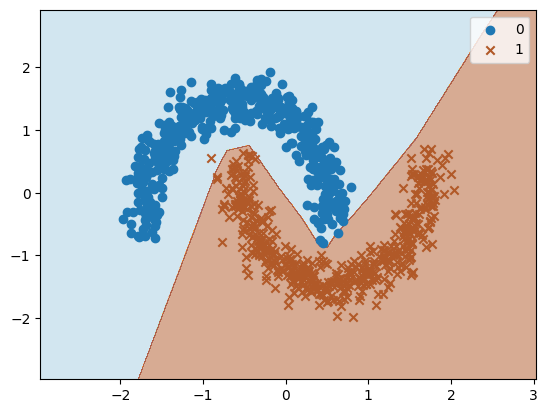

In [53]:
index = 0

model = MLP(2, [8], 1)
X, y = get_moons_dataset(1000, 0.1)
weights, angle = dataset[index]
angle = angle.numpy().dot([0, 45, 90, 135, 180, 225, 270, 315])
X_rotated = rotate(X, angle)
# list_to_model(model, weights.tolist())
# plot_decision_boundary(model, X, y)

variational.to("cpu")
variational.eval()
with torch.no_grad():
    _, mean, var = variational(weights.unsqueeze(0))
    latent = variational.reparameterize(mean, var)
    out = variational.decoder(latent)
    list_to_model(model, out[0].tolist())
    plot_decision_boundary(model, X_rotated, y)


## Bigger latent space

In [807]:
class Variational(torch.nn.Module):
    def __init__(self) -> None:
        super(Variational, self).__init__()
        
        self.encoder = self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
        )

        self.decoder = self.decoder = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 33),
        )

        self.mean = torch.nn.Linear(128, 128)
        self.log_var = torch.nn.Linear(128, 128)
    
    def reparameterize(self, mean, log_var):
        var = torch.exp(0.5*log_var)
        epsilon = torch.randn_like(var)     
        latent = mean + var*epsilon
        return latent

    def forward(self, x):
        latent = self.encoder(x)
        mean = self.mean(latent)
        log_var = self.log_var(latent)
        x = self.reparameterize(mean, log_var)
        output = self.decoder(x)
        return output, mean, log_var


config = {
    "model":{
        "name": "Variational Autoencoder",
        "layers": [33, 512, 1024, 512, 256, 128]
    },
    "hyperparameters":{
        "epochs": 100,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam",
        "kl_weight": 1
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]
kl_weight = hyperparameters["kl_weight"]


torch.manual_seed(42)

variational = Variational()
variational.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(variational.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda:0")

dataset = ModelParamsDataset("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

In [808]:
# wandb_config = cfg.load_env()
# run = wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="variational_autoencoder_with_bigger_latent_space")

# for i in tqdm(range(epochs)):
variational.train()
variational.to(device)
for i in tqdm(range(101)):
    for X, y in dataloader:
        X = X.to(device)
        output, mean, log_var = variational(X)

        loss = loss_fn(output, X)
        # kl_div = -0.5*torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        # loss += (kl_weight * kl_div)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # wandb.log({"loss": loss.item()})
    if(i % 5 == 0):
        print(f'Epoch: {i+1}, Loss: {loss.item()}')
        torch.save(variational.state_dict(), f"../models/variationals/variational_{i}.pth")
    
torch.save(variational.state_dict(), f"../models/variationals/variational_final.pth")


# model_path = "../models/variational_autoencoder_with_larger_latent_space.pth"
# torch.save(variational.state_dict(), model_path)

# model_artifact = wandb.Artifact("variational_autoencoder", type="model")
# model_artifact.add_file(model_path)
# run.log_artifact(model_artifact)
# wandb.finish()

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 1, Loss: 2.4808034896850586
Epoch: 6, Loss: 0.6048847436904907
Epoch: 11, Loss: 0.3190850019454956
Epoch: 16, Loss: 0.1970720887184143
Epoch: 21, Loss: 0.19026197493076324
Epoch: 26, Loss: 0.14672434329986572
Epoch: 31, Loss: 0.11896364390850067
Epoch: 36, Loss: 0.1182083934545517
Epoch: 41, Loss: 0.09715072810649872
Epoch: 46, Loss: 0.13102884590625763
Epoch: 51, Loss: 0.0757676437497139
Epoch: 56, Loss: 0.07451584190130234
Epoch: 61, Loss: 2.5501911640167236
Epoch: 66, Loss: 0.11606099456548691
Epoch: 71, Loss: 0.08227162063121796
Epoch: 76, Loss: 0.08147488534450531
Epoch: 81, Loss: 0.07710977643728256
Epoch: 86, Loss: 0.06816228479146957
Epoch: 91, Loss: 0.058721546083688736
Epoch: 96, Loss: 0.062212515622377396
Epoch: 101, Loss: 0.06342661380767822


In [42]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

data_raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data_raw[:, -1]
data = data_raw[:, 1:-1]

(80000, 128)
(80000, 3)


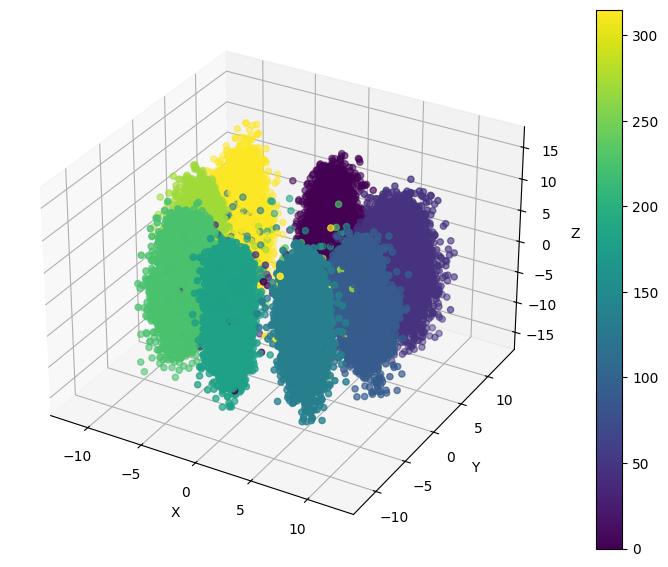

In [921]:
index = 40
variational.load_state_dict(torch.load(f"../models/variationals/variational_{index}.pth"))
variational.eval()
variational.to("cpu")
latent = variational.encoder(torch.tensor(data).float()).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(0, 0, 90)

plt.show()

90.0 135.0


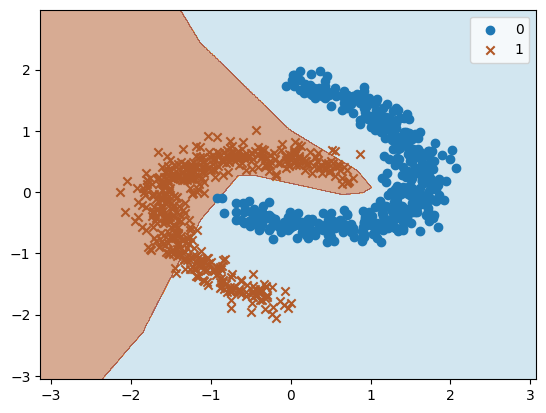

In [922]:
X, y = get_moons_dataset(1000, 0.1)
model = MLP(2, [8], 1)

index1 = 72043
index2 = 11004

angle1 = angles[index1]
angle2 = angles[index2]
print(angle1, angle2)
weights1 = torch.tensor(data[index1]).float()
weights2 = torch.tensor(data[index2]).float()

mean1 = variational.mean(variational.encoder(weights1.unsqueeze(0)))
log_var1 = variational.log_var(variational.encoder(weights1.unsqueeze(0)))
mean2 = variational.mean(variational.encoder(weights2.unsqueeze(0)))
log_var2 = variational.log_var(variational.encoder(weights2.unsqueeze(0)))

alpha = 0.5
mean = (1-alpha)*mean1 + alpha*mean2
log_var = (1-alpha)*log_var1 + alpha*log_var2
angle = (1-alpha)*angle1 + alpha*angle2


latent = variational.reparameterize(mean, log_var)
output = variational.decoder(latent)

X_rotated = rotate(X, angle)
list_to_model(model, output[0].tolist())
plot_decision_boundary(model, X_rotated, y)

In [926]:
raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = raw[:, -1]
weights = raw[:, 1:-1]
X,y = get_moons_dataset(1000, 0.1)

weights_0 = weights[angles == 0]
weights_45 = weights[angles == 45]
weights_90 = weights[angles == 90]
weights_135 = weights[angles == 135]
weights_180 = weights[angles == 180]

weights = [weights_0, weights_45, weights_90, weights_135, weights_180]
angles = [0, 45, 90, 135, 180]

variational = Variational()
model = MLP(2, [8], 1)
variational.eval()

accuracies = {}

for i in tqdm(range(0,101,5)):
    variational.load_state_dict(torch.load(f"../models/variationals/variational_{index}.pth"))
    accuracies[i] = []

    for j in range(4):
        for k in range(10000):
            weights_1 = weights[j][k]
            weights_2 = weights[j+1][k]

            mean1 = variational.mean(variational.encoder(torch.tensor(weights_1).float().unsqueeze(0)))
            log_var1 = variational.log_var(variational.encoder(torch.tensor(weights_1).float().unsqueeze(0)))
            mean2 = variational.mean(variational.encoder(torch.tensor(weights_2).float().unsqueeze(0)))
            log_var2 = variational.log_var(variational.encoder(torch.tensor(weights_2).float().unsqueeze(0)))
            alpha = 0.5
            mean = alpha*mean1 + (1-alpha)*mean2
            log_var = alpha*log_var1 + (1-alpha)*log_var2

            latent = variational.reparameterize(mean, log_var)
            output = variational.decoder(latent)

            angle = alpha*angles[j] + (1-alpha)*angles[j+1]
            X_rotated = rotate(X, angle)

            list_to_model(model, output[0].tolist())
            accuracy = get_accuracy(model, X_rotated, y)
            accuracies[i].append(accuracy)


  0%|          | 0/21 [00:00<?, ?it/s]

In [927]:
for key, value in accuracies.items():
    value = np.mean(value)
    print(f"{key}: {value}")

0: 84.15910749999999
5: 84.15859999999999
10: 84.1590275
15: 84.1595275
20: 84.159085
25: 84.15957
30: 84.15972000000002
35: 84.15906
40: 84.15965
45: 84.16008500000001
50: 84.15876999999999
55: 84.15993
60: 84.15984749999998
65: 84.1591675
70: 84.160015
75: 84.15914000000001
80: 84.1592875
85: 84.15836
90: 84.158715
95: 84.15870749999999
100: 84.15971500000002


In [929]:
raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = raw[:, -1]
weights = raw[:, 1:-1]
X,y = get_moons_dataset(1000, 0.1)

variational = Variational()
model = MLP(2, [8], 1)
variational.eval()

accuracies = {}

for i in tqdm(range(0,101,5)):
    variational.load_state_dict(torch.load(f"../models/variationals/variational_{index}.pth"))
    accuracies[i] = []

    for k in range(80000):
        weights_1 = weights[k]

        mean = variational.mean(variational.encoder(torch.tensor(weights_1).float().unsqueeze(0)))
        log_var = variational.log_var(variational.encoder(torch.tensor(weights_1).float().unsqueeze(0)))

        latent = variational.reparameterize(mean, log_var)
        output = variational.decoder(latent)

        X_rotated = rotate(X, angles[k])

        list_to_model(model, output[0].tolist())
        accuracy = get_accuracy(model, X_rotated, y)
        accuracies[i].append(accuracy)

  0%|          | 0/21 [00:00<?, ?it/s]

In [930]:
for key, value in accuracies.items():
    value = np.mean(value)
    print(f"{key}: {value}")

0: 98.66152750000002
5: 98.6611975
10: 98.66124375
15: 98.66129875
20: 98.66175125000001
25: 98.66149999999999
30: 98.66177624999999
35: 98.66159875000001
40: 98.6617675
45: 98.66161250000002
50: 98.66125
55: 98.661475
60: 98.6614175
65: 98.66142500000001
70: 98.6611675
75: 98.66160875
80: 98.66167250000001
85: 98.66134999999998
90: 98.66159125
95: 98.6615775
100: 98.66159250000003


In [933]:
class Autoencoder(torch.nn.Module):
    def __init__(self) -> None:
        super(Autoencoder, self).__init__()
        
        self.encoder = self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
        )

        self.decoder = self.decoder = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 33),
        )


    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output


config = {
    "model":{
        "name": "Autoencoder",
        "layers": [33, 512, 1024, 512, 256, 128]
    },
    "hyperparameters":{
        "epochs": 100,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam",
        "kl_weight": 1
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]
kl_weight = hyperparameters["kl_weight"]


torch.manual_seed(42)

autoencoder = Autoencoder()
autoencoder.to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda:0")

dataset = ModelParamsDataset("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

In [934]:
autoencoder.train()
autoencoder.to(device)
for i in tqdm(range(101)):
    for X, y in dataloader:
        X = X.to(device)
        output = autoencoder(X)
        loss = loss_fn(output, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if(i % 5 == 0):
        print(f'Epoch: {i+1}, Loss: {loss.item()}')
        torch.save(autoencoder.state_dict(), f"../models/autoencoders/autoencoder_{i}.pth")
    
torch.save(autoencoder.state_dict(), f"../models/autoencoders/autoencoder_final.pth")

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 1, Loss: 2.488947629928589
Epoch: 6, Loss: 0.9477817416191101
Epoch: 11, Loss: 0.4481561481952667
Epoch: 16, Loss: 0.26001396775245667
Epoch: 21, Loss: 0.2074785679578781
Epoch: 26, Loss: 0.16050589084625244
Epoch: 31, Loss: 0.13211020827293396
Epoch: 36, Loss: 0.10470175743103027
Epoch: 41, Loss: 0.09259380400180817
Epoch: 46, Loss: 0.07999373227357864
Epoch: 51, Loss: 0.07895400375127792
Epoch: 56, Loss: 0.06836465746164322
Epoch: 61, Loss: 0.06266950815916061
Epoch: 66, Loss: 0.05211431905627251
Epoch: 71, Loss: 0.04749250039458275
Epoch: 76, Loss: 0.05139071121811867
Epoch: 81, Loss: 0.0485372431576252
Epoch: 86, Loss: 0.04730040580034256
Epoch: 91, Loss: 0.03753722086548805
Epoch: 96, Loss: 0.04152845963835716
Epoch: 101, Loss: 0.05105685070157051


(80000, 128)
(80000, 3)


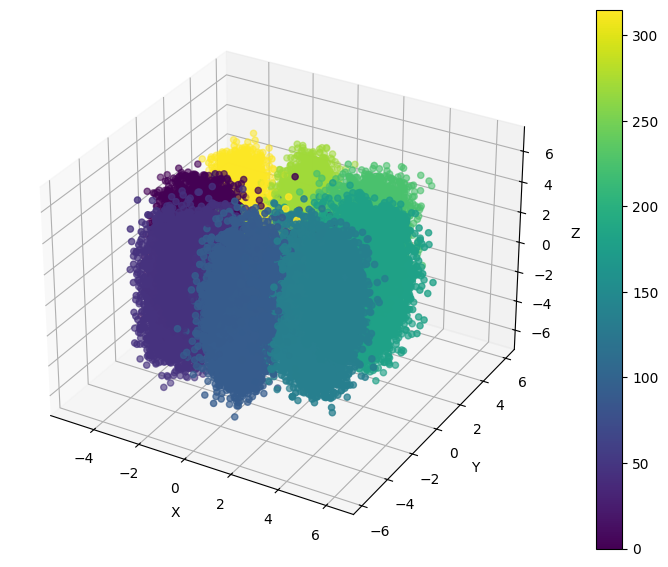

In [938]:
index = 15
autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_{index}.pth"))
autoencoder.eval()
autoencoder.to("cpu")
latent = autoencoder.encoder(torch.tensor(data).float()).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(0, 0, 90)

plt.show()

90.0 135.0


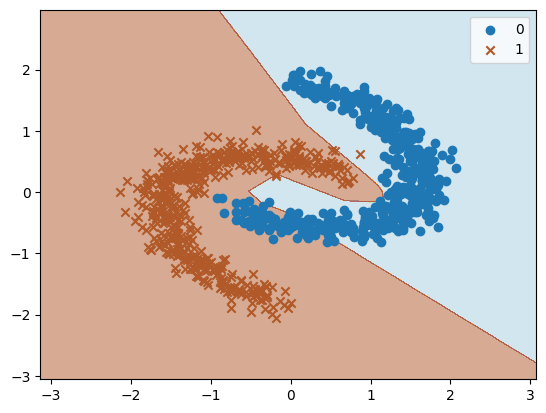

In [942]:
X, y = get_moons_dataset(1000, 0.1)
model = MLP(2, [8], 1)

index1 = 72043
index2 = 11004

angle1 = angles[index1]
angle2 = angles[index2]
print(angle1, angle2)
weights1 = torch.tensor(data[index1]).float()
weights2 = torch.tensor(data[index2]).float()

latent1 = autoencoder.encoder(weights1.unsqueeze(0))
latent2 = autoencoder.encoder(weights2.unsqueeze(0))

alpha = 0.5
latent = (1-alpha)*latent1 + alpha*latent2
angle = (1-alpha)*angle1 + alpha*angle2

output = autoencoder.decoder(latent)

X_rotated = rotate(X, angle)
list_to_model(model, output[0].tolist())
plot_decision_boundary(model, X_rotated, y)

In [946]:
raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = raw[:, -1]
weights = raw[:, 1:-1]
X,y = get_moons_dataset(1000, 0.1)

weights_0 = weights[angles == 0]
weights_45 = weights[angles == 45]
weights_90 = weights[angles == 90]
weights_135 = weights[angles == 135]
weights_180 = weights[angles == 180]

weights = [weights_0, weights_45, weights_90, weights_135, weights_180]
angles = [0, 45, 90, 135, 180]

autoencoder = Autoencoder()
model = MLP(2, [8], 1)
autoencoder.eval()

accuracies = {}

for i in tqdm(range(0,101,5)):
    autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_{index}.pth"))
    accuracies[i] = []

    for j in range(4):
        for k in range(10000):
            weights_1 = weights[j][k]
            weights_2 = weights[j+1][k]

            latent1 = autoencoder.encoder(torch.tensor(weights_1).float().unsqueeze(0))
            latent2 = autoencoder.encoder(torch.tensor(weights_2).float().unsqueeze(0))

            latent = (1-alpha)*latent1 + alpha*latent2
            output = autoencoder.decoder(latent)
            angle = alpha*angles[j] + (1-alpha)*angles[j+1]
            X_rotated = rotate(X, angle)

            list_to_model(model, output[0].tolist())
            accuracy = get_accuracy(model, X_rotated, y)
            accuracies[i].append(accuracy)


  0%|          | 0/21 [00:00<?, ?it/s]

In [947]:
for key, value in accuracies.items():
    value = np.mean(value)
    print(f"{key}: {value}")

0: 87.43691000000001
5: 87.43691000000001
10: 87.43691000000001
15: 87.43691000000001
20: 87.43691000000001
25: 87.43691000000001
30: 87.43691000000001
35: 87.43691000000001
40: 87.43691000000001
45: 87.43691000000001
50: 87.43691000000001
55: 87.43691000000001
60: 87.43691000000001
65: 87.43691000000001
70: 87.43691000000001
75: 87.43691000000001
80: 87.43691000000001
85: 87.43691000000001
90: 87.43691000000001
95: 87.43691000000001
100: 87.43691000000001


In [3]:
raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = raw[:, -1]
weights = raw[:, 1:-1]
X,y = get_moons_dataset(1000, 0.1)

autoencoder = Autoencoder()
model = MLP(2, [8], 1)
autoencoder.eval()

accuracies = {}

for i in tqdm(range(0,101,5)):
    autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_{index}.pth"))
    accuracies[i] = []

    for k in range(80000):
        weights_1 = weights[k]

        output = autoencoder(torch.tensor(weights_1).float().unsqueeze(0))
        X_rotated = rotate(X, angles[k])
        list_to_model(model, output[0].tolist())
        accuracy = get_accuracy(model, X_rotated, y)
        accuracies[i].append(accuracy)

NameError: name 'Autoencoder' is not defined

In [944]:
for key, value in accuracies.items():
    value = np.mean(value)
    print(f"{key}: {value}")

0: 95.9449025
5: 95.9449025
10: 95.9449025
15: 95.9449025
20: 95.9449025
25: 95.9449025
30: 95.9449025
35: 95.9449025
40: 95.9449025
45: 95.9449025
50: 95.9449025
55: 95.9449025
60: 95.9449025
65: 95.9449025
70: 95.9449025
75: 95.9449025
80: 95.9449025
85: 95.9449025
90: 95.9449025
95: 95.9449025
100: 95.9449025


## Force the first latent be angle

In [4]:
class Autoencoder(torch.nn.Module):
    def __init__(self) -> None:
        super(Autoencoder, self).__init__()
        
        self.encoder = self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
        )

        self.decoder = self.decoder = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 33),
        )


    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output


config = {
    "model":{
        "name": "Autoencoder",
        "layers": [33, 512, 1024, 512, 256, 128]
    },
    "hyperparameters":{
        "epochs": 100,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam",
        "kl_weight": 1
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]
kl_weight = hyperparameters["kl_weight"]


torch.manual_seed(42)

autoencoder = Autoencoder()
autoencoder.to(device)
loss_fn = torch.nn.MSELoss()
latent_loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda:0")

dataset = ModelParamsDataset("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

In [40]:
angles = torch.tensor([0, 45, 90, 135, 180, 225, 270, 315], dtype=torch.float32)
angles = angles/360
for i in tqdm(range(101)):
    for X, y in dataloader:
        X = X.to(device)
        angle = torch.matmul(y, angles.T)
        latent = autoencoder.encoder(X)
        output = autoencoder.decoder(latent)

        latent_constrained = latent.clone()
        latent_constrained[:, 0] = angle
        
        loss = loss_fn(output, X)
        loss += latent_loss(latent, latent_constrained)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if(i % 5 == 0):
        print(f'Epoch: {i+1}, Loss: {loss.item()}')
        torch.save(autoencoder.state_dict(), f"../models/autoencoders/autoencoder_{i}.pth")
    
torch.save(autoencoder.state_dict(), f"../models/autoencoders/autoencoder_final.pth")

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 1, Loss: 3.0099329948425293
Epoch: 6, Loss: 1.1479542255401611
Epoch: 11, Loss: 0.6570162177085876
Epoch: 16, Loss: 0.3181898593902588
Epoch: 21, Loss: 0.21660833060741425
Epoch: 26, Loss: 0.1524018496274948
Epoch: 31, Loss: 0.10940634459257126
Epoch: 36, Loss: 0.08933381736278534
Epoch: 41, Loss: 0.0754254013299942
Epoch: 46, Loss: 0.05454573407769203
Epoch: 51, Loss: 0.04352659732103348
Epoch: 56, Loss: 0.040775664150714874
Epoch: 61, Loss: 0.0395020917057991
Epoch: 66, Loss: 0.03034224733710289
Epoch: 71, Loss: 0.03148472681641579
Epoch: 76, Loss: 0.022003604099154472
Epoch: 81, Loss: 0.020318321883678436
Epoch: 86, Loss: 0.020339736714959145
Epoch: 91, Loss: 0.017176873981952667
Epoch: 96, Loss: 0.01727980747818947
Epoch: 101, Loss: 0.010695449076592922


In [53]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data_raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data_raw[:, -1]
data = data_raw[:, 1:-1]

(80000, 128)
(80000, 3)


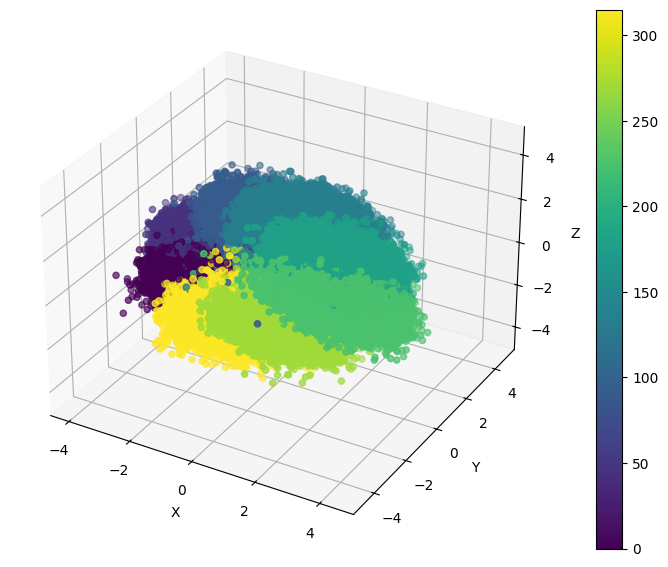

In [13]:
index = 25
autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_{index}.pth"))
autoencoder.eval()
autoencoder.to("cpu")
latent = autoencoder.encoder(torch.tensor(data).float()).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(0, 0, 90)

plt.show()

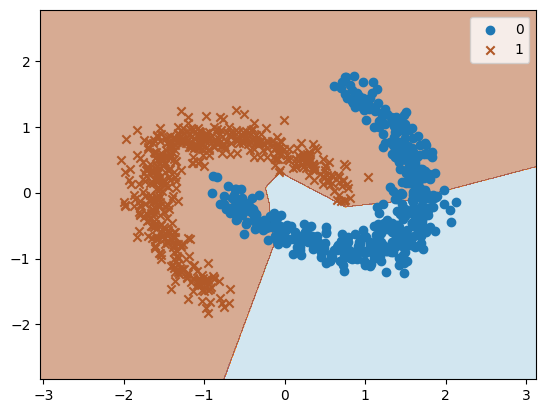

In [15]:
index = 12002
model = MLP(2, [8], 1)
input = torch.tensor(data[index]).float()
latent = autoencoder.encoder(input.unsqueeze(0))
latent[0] += -1
output = autoencoder.decoder(latent)
angle = angles[index]
X_rotated = rotate(X, angle)
list_to_model(model, output[0].tolist())
plot_decision_boundary(model, X_rotated, y)


90.0 135.0


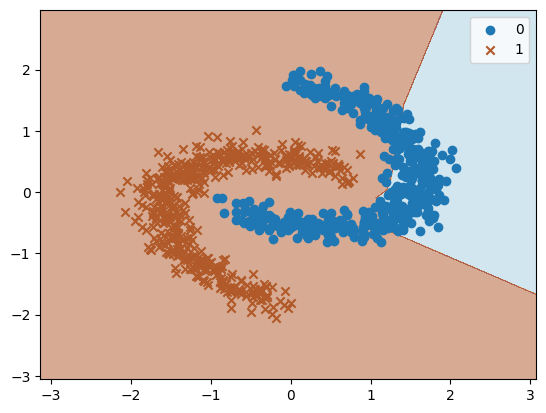

In [112]:
X, y = get_moons_dataset(1000, 0.1)
model = MLP(2, [8], 1)

index1 = 72043
index2 = 11004

angle1 = angles[index1]
angle2 = angles[index2]
print(angle1, angle2)
weights1 = torch.tensor(data[index1]).float()
weights2 = torch.tensor(data[index2]).float()

latent1 = autoencoder.encoder(weights1.unsqueeze(0))
latent2 = autoencoder.encoder(weights2.unsqueeze(0))

alpha = 0.5
latent = (1-alpha)*latent1 + alpha*latent2
angle = (1-alpha)*angle1 + alpha*angle2

output = autoencoder.decoder(latent)

X_rotated = rotate(X, angle)
list_to_model(model, output[0].tolist())
plot_decision_boundary(model, X_rotated, y)

In [19]:
raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = raw[:, -1]
weights = raw[:, 1:-1]
X,y = get_moons_dataset(1000, 0.1)

weights_0 = weights[angles == 0]
weights_45 = weights[angles == 45]
weights_90 = weights[angles == 90]
weights_135 = weights[angles == 135]
weights_180 = weights[angles == 180]

weights = [weights_0, weights_45, weights_90, weights_135, weights_180]
angles = [0, 45, 90, 135, 180]

autoencoder = Autoencoder()
model = MLP(2, [8], 1)
autoencoder.eval()

accuracies = {}
alpha = 0.5

for i in tqdm(range(0,101,5)):
    autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_{i}.pth"))
    accuracies[i] = []

    for j in range(4):
        for k in range(10000):
            weights_1 = weights[j][k]
            weights_2 = weights[j+1][k]

            latent1 = autoencoder.encoder(torch.tensor(weights_1).float().unsqueeze(0))
            latent2 = autoencoder.encoder(torch.tensor(weights_2).float().unsqueeze(0))

            latent = (1-alpha)*latent1 + alpha*latent2
            output = autoencoder.decoder(latent)
            angle = alpha*angles[j] + (1-alpha)*angles[j+1]
            X_rotated = rotate(X, angle)

            list_to_model(model, output[0].tolist())
            accuracy = get_accuracy(model, X_rotated, y)
            accuracies[i].append(accuracy)


  0%|          | 0/21 [00:00<?, ?it/s]

In [21]:
for key, value in accuracies.items():
    value = np.mean(value)
    print(f"{key}: {value}")

0: 60.7601875
5: 86.54323000000001
10: 87.50413250000001
15: 87.43221750000001
20: 86.77547249999999
25: 85.7239075
30: 85.26776
35: 85.211095
40: 84.6724375
45: 84.77470500000001
50: 83.12288249999999
55: 82.3278125
60: 81.51118000000001
65: 81.33277749999999
70: 80.8505225
75: 79.88949000000001
80: 79.852965
85: 79.39198
90: 78.70982
95: 78.13536749999999
100: 78.03871


In [23]:
raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = raw[:, -1]
weights = raw[:, 1:-1]
X,y = get_moons_dataset(1000, 0.1)

autoencoder = Autoencoder()
model = MLP(2, [8], 1)
autoencoder.eval()

accuracies = {}

for i in tqdm(range(0,101,5)):
    autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_{i}.pth"))
    accuracies[i] = []

    for k in range(80000):
        weights_1 = weights[k]

        output = autoencoder(torch.tensor(weights_1).float().unsqueeze(0))
        X_rotated = rotate(X, angles[k])
        list_to_model(model, output[0].tolist())
        accuracy = get_accuracy(model, X_rotated, y)
        accuracies[i].append(accuracy)

  0%|          | 0/21 [00:00<?, ?it/s]

In [24]:
for key, value in accuracies.items():
    value = np.mean(value)
    print(f"{key}: {value}")

0: 64.51684875
5: 88.43383
10: 91.9005275
15: 94.72209375
20: 96.28767125
25: 97.478015
30: 97.86908125000001
35: 98.36953374999999
40: 98.90124000000002
45: 99.14516125
50: 99.11197625
55: 99.40019000000001
60: 99.48195125000001
65: 99.43148750000002
70: 99.38360374999999
75: 99.62463374999999
80: 99.68164250000001
85: 99.61214125000001
90: 99.69743000000001
95: 99.679245
100: 99.75231749999998


## Saved variational autoencoder

In [3]:
from src.model.models import Variational, MLP

dataset = ModelParamsDataset2("../data/eight_angles_small.csv", 45)
# dataset.normalize()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
X, y = get_moons_dataset(1000, 0.1)

variational = Variational()
variational.load_state_dict(torch.load("../models/variational_autoencoder.pth"))

model = MLP(2, [8], 1)
weights, angle = dataset[25]
weights = weights.unsqueeze(0)
variational.eval()
with torch.no_grad():
    _, mean, var = variational(weights)
    latent = variational.reparameterize(mean, var)
    output = variational.decoder(latent).squeeze()
    list_to_model(model, output.tolist())

    plot_decision_boundary(model, X, y)

RuntimeError: Error(s) in loading state_dict for Variational:
	Missing key(s) in state_dict: "log_var.weight", "log_var.bias". 
	Unexpected key(s) in state_dict: "var.weight", "var.bias". 

In [729]:
data_raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data_raw[:, -1]
data = data_raw[:, 1:-1]

latent_space = variational.encoder(torch.tensor(data).float()).detach().numpy()
print(latent_space.shape)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (80000x33 and 10x128)

## Latent autoencoder

In [28]:
def reparameterize(mean, var):
    std = torch.exp(0.5*var)
    eps = torch.randn_like(std)
    return mean + eps*std

class Variational(torch.nn.Module):
    def __init__(self) -> None:
        super(Variational, self).__init__()
        
        self.encoder = self.encoder = torch.nn.Sequential(
            torch.nn.Linear(10, 10),
        )

        self.decoder = self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 10),
        )

        self.mean = torch.nn.Linear(10, 10)
        self.var = torch.nn.Linear(10, 10)

    def forward(self, x):
        latent = self.encoder(x)
        mean = self.mean(latent)
        var = self.var(latent)
        x = reparameterize(mean, var)
        output = self.decoder(x)
        return output, mean, var


config = {
    "model":{
        "name": "Variational Autoencoder",
        "layers": [10, 10]
    },
    "hyperparameters":{
        "epochs": 100,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam"
    }
}

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

wandb_config = cfg.load_env()
run = wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="latent_variational_autoencoder")

variational = Variational()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(variational.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda:0")

dataset = ModelParamsDataset2("../data/eight_angles_small_latent.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


for i in tqdm(range(epochs)):
    for X, y in dataloader:
        output, mean, var = variational(X)

        loss = loss_fn(output, X)
        kl_div = -0.5*torch.sum(1 + var - mean.pow(2) - var.exp())
        loss += kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    wandb.log({"loss": loss.item()})
    print(f'Epoch: {i+1}, Loss: {loss.item()}')


model_path = "../models/variational_autoencoder.pth"
torch.save(variational.state_dict(), model_path)

model_artifact = wandb.Artifact("variational_autoencoder", type="model")
model_artifact.add_file(model_path)
run.log_artifact(model_artifact)
wandb.finish()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Loss: 30.545482635498047
Epoch: 2, Loss: 28.553462982177734
Epoch: 3, Loss: 26.346975326538086
Epoch: 4, Loss: 27.512630462646484
Epoch: 5, Loss: 27.6855411529541
Epoch: 6, Loss: 32.071800231933594
Epoch: 7, Loss: 31.77876091003418
Epoch: 8, Loss: 32.03046417236328
Epoch: 9, Loss: 31.526735305786133
Epoch: 10, Loss: 31.75876235961914
Epoch: 11, Loss: 25.53885269165039
Epoch: 12, Loss: 27.728994369506836
Epoch: 13, Loss: 26.57550048828125
Epoch: 14, Loss: 27.011756896972656
Epoch: 15, Loss: 27.56927490234375
Epoch: 16, Loss: 30.858036041259766
Epoch: 17, Loss: 28.897911071777344
Epoch: 18, Loss: 28.77895164489746
Epoch: 19, Loss: 28.99972915649414
Epoch: 20, Loss: 27.851669311523438
Epoch: 21, Loss: 30.642263412475586
Epoch: 22, Loss: 30.64933967590332
Epoch: 23, Loss: 28.599924087524414
Epoch: 24, Loss: 27.264225006103516
Epoch: 25, Loss: 28.909019470214844
Epoch: 26, Loss: 28.69894027709961
Epoch: 27, Loss: 31.978593826293945
Epoch: 28, Loss: 26.272388458251953
Epoch: 29, Lo

loss,▇▃██▃▄▇▅▇▅▅▃▆▂▇▇▆▅▇▇▆▄▆▅▆▇▇▅▂▁█▆▇▃▇▄▄▅▇▅
loss,28.55584


In [29]:
def reparameterize(mean, var):
    std = torch.exp(0.5*var)
    eps = torch.randn_like(std)
    return mean + eps*std

class Variational(torch.nn.Module):
    def __init__(self) -> None:
        super(Variational, self).__init__()
        
        self.encoder = self.encoder = torch.nn.Sequential(
            torch.nn.Linear(10, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 10),
        )

        self.decoder = self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10),
        )

        self.mean = torch.nn.Linear(10, 10)
        self.var = torch.nn.Linear(10, 10)

    def forward(self, x):
        latent = self.encoder(x)
        mean = self.mean(latent)
        var = self.var(latent)
        x = reparameterize(mean, var)
        output = self.decoder(x)
        return output, mean, var


config = {
    "model":{
        "name": "Variational Autoencoder",
        "layers": [10, 128, 64, 16, 10]
    },
    "hyperparameters":{
        "epochs": 100,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam"
    }
}

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]

wandb_config = cfg.load_env()
run = wandb.init(project=wandb_config["WANDB_PROJECT"], entity=wandb_config["WANDB_ENTITY"], config=config, group="latent_variational_autoencoder")

variational = Variational()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(variational.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda:0")

dataset = ModelParamsDataset2("../data/eight_angles_small_latent.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


for i in tqdm(range(epochs)):
    for X, y in dataloader:
        output, mean, var = variational(X)

        loss = loss_fn(output, X)
        kl_div = -0.5*torch.sum(1 + var - mean.pow(2) - var.exp())
        loss += kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    wandb.log({"loss": loss.item()})
    print(f'Epoch: {i+1}, Loss: {loss.item()}')


model_path = "../models/variational_autoencoder.pth"
torch.save(variational.state_dict(), model_path)

model_artifact = wandb.Artifact("variational_autoencoder", type="model")
model_artifact.add_file(model_path)
run.log_artifact(model_artifact)
wandb.finish()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Loss: 31.029645919799805
Epoch: 2, Loss: 29.511457443237305
Epoch: 3, Loss: 30.30040740966797
Epoch: 4, Loss: 33.564334869384766
Epoch: 5, Loss: 27.231557846069336
Epoch: 6, Loss: 28.10177230834961
Epoch: 7, Loss: 26.669937133789062
Epoch: 8, Loss: 29.468013763427734
Epoch: 9, Loss: 28.609798431396484
Epoch: 10, Loss: 26.35608673095703
Epoch: 11, Loss: 30.262149810791016
Epoch: 12, Loss: 28.450359344482422
Epoch: 13, Loss: 25.97445297241211
Epoch: 14, Loss: 31.07881736755371
Epoch: 15, Loss: 26.63020133972168
Epoch: 16, Loss: 29.703567504882812
Epoch: 17, Loss: 29.00380516052246
Epoch: 18, Loss: 30.51124382019043
Epoch: 19, Loss: 28.208080291748047
Epoch: 20, Loss: 25.77058982849121
Epoch: 21, Loss: 28.972702026367188
Epoch: 22, Loss: 27.948196411132812
Epoch: 23, Loss: 30.978687286376953
Epoch: 24, Loss: 28.187509536743164
Epoch: 25, Loss: 27.871070861816406
Epoch: 26, Loss: 24.583383560180664
Epoch: 27, Loss: 29.30718994140625
Epoch: 28, Loss: 31.84000015258789
Epoch: 29, L

loss,▆▅▄▅▅▂▅▅▄▆▁▆▃▄▇█▅▂▅▅▄▁▅▅▄▇▃▄▅▃▄▃▇▆▆▃▂▄▄▃
loss,27.81127


## Contrastive loss

In [50]:
class Autoencoder(torch.nn.Module):
    def __init__(self) -> None:
        super(Autoencoder, self).__init__()
        
        self.encoder = self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
        )

        self.decoder = self.decoder = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 33),
        )


    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, latent1, latent2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(latent1, latent2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

config = {
    "model":{
        "name": "Autoencoder",
        "layers": [33, 512, 1024, 512, 256, 128]
    },
    "hyperparameters":{
        "epochs": 100,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam",
        "kl_weight": 1
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]
kl_weight = hyperparameters["kl_weight"]


torch.manual_seed(42)

autoencoder = Autoencoder()
autoencoder.to(device)
loss_fn = torch.nn.MSELoss()
latent_loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda:0")

dataset = ModelParamsDataset("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

contrastive_loss = ContrastiveLoss()

In [51]:
angles = torch.tensor([0, 45, 90, 135, 180, 225, 270, 315], dtype=torch.float32).to(device)
angles = angles/360
labels = torch.tensor([0]*50).to(device)
for i in tqdm(range(301)):
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        latent = autoencoder.encoder(X)
        output = autoencoder.decoder(latent)

        loss = loss_fn(output, X)
        pair_1 = latent[::2]
        pair_2 = latent[1::2]
        angle = torch.matmul(y, angles.T)
        mask = angle[::2] == angle[1::2]
        label = labels.clone()
        label[mask] = 1
        loss_contrastive = contrastive_loss(pair_1, pair_2, label)
        loss += (loss_contrastive/2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if(i % 5 == 0):
        print(f'Epoch: {i+1}, Loss: {loss.item()}')
        torch.save(autoencoder.state_dict(), f"../models/autoencoders/autoencoder_{i}.pth")
    
torch.save(autoencoder.state_dict(), f"../models/autoencoders/autoencoder_final.pth")

  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 1, Loss: 3.955724000930786
Epoch: 6, Loss: 3.0266783237457275
Epoch: 11, Loss: 2.6983895301818848
Epoch: 16, Loss: 2.510890483856201
Epoch: 21, Loss: 2.2774055004119873
Epoch: 26, Loss: 2.2474348545074463
Epoch: 31, Loss: 2.099078416824341
Epoch: 36, Loss: 1.999555230140686
Epoch: 41, Loss: 1.9412351846694946
Epoch: 46, Loss: 1.8608099222183228
Epoch: 51, Loss: 1.8545511960983276
Epoch: 56, Loss: 1.8113987445831299
Epoch: 61, Loss: 1.5938758850097656
Epoch: 66, Loss: 1.5611467361450195
Epoch: 71, Loss: 1.5381745100021362
Epoch: 76, Loss: 1.464786171913147
Epoch: 81, Loss: 1.499057650566101
Epoch: 86, Loss: 1.391053318977356
Epoch: 91, Loss: 1.420736312866211
Epoch: 96, Loss: 1.2774900197982788
Epoch: 101, Loss: 1.3426523208618164
Epoch: 106, Loss: 1.239470362663269
Epoch: 111, Loss: 1.2750797271728516
Epoch: 116, Loss: 1.250754952430725
Epoch: 121, Loss: 1.1789586544036865
Epoch: 126, Loss: 1.1188679933547974
Epoch: 131, Loss: 1.0950571298599243
Epoch: 136, Loss: 1.0980521440505

In [62]:
autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_300.pth"))
accuracies = []
X,y = get_moons_dataset(1000, 0.1)
model = MLP(2, [8], 1)

data_raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data_raw[:, -1]
data = data_raw[:, 1:-1]

for k in tqdm(range(80000)):
    weights_1 = data[k]

    output = autoencoder(torch.tensor(weights_1).float().unsqueeze(0))
    X_rotated = rotate(X, angles[k])
    list_to_model(model, output[0].tolist())
    accuracy = get_accuracy(model, X_rotated, y)
    accuracies.append(accuracy)

print(np.mean(accuracies))

  0%|          | 0/80000 [00:00<?, ?it/s]

In [65]:
raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = raw[:, -1]
weights = raw[:, 1:-1]
X,y = get_moons_dataset(1000, 0.1)

weights_0 = weights[angles == 0]
weights_45 = weights[angles == 45]
weights_90 = weights[angles == 90]
weights_135 = weights[angles == 135]
weights_180 = weights[angles == 180]

weights = [weights_0, weights_45, weights_90, weights_135, weights_180]
angles = [0, 45, 90, 135, 180]

autoencoder = Autoencoder()
model = MLP(2, [8], 1)
autoencoder.eval()

accuracies = []
alpha = 0.5

autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_300.pth"))

for j in tqdm(range(4)):
    for k in range(10000):
        weights_1 = weights[j][k]
        weights_2 = weights[j+1][k]

        latent1 = autoencoder.encoder(torch.tensor(weights_1).float().unsqueeze(0))
        latent2 = autoencoder.encoder(torch.tensor(weights_2).float().unsqueeze(0))

        latent = (1-alpha)*latent1 + alpha*latent2
        output = autoencoder.decoder(latent)
        angle = alpha*angles[j] + (1-alpha)*angles[j+1]
        X_rotated = rotate(X, angle)

        list_to_model(model, output[0].tolist())
        accuracy = get_accuracy(model, X_rotated, y)
        accuracies.append(accuracy)

  0%|          | 0/4 [00:00<?, ?it/s]

In [66]:
print(np.mean(accuracies))

84.656575


In [43]:
for key, value in accuracies.items():
    value = np.mean(value)
    print(f"{key}: {value}")

0: 52.62928374999999
5: 72.67505375
10: 76.51756125
15: 79.24679625
20: 80.99727125
25: 82.63270125
30: 83.83192
35: 84.53405375
40: 84.94847625000001
45: 85.42581000000001
50: 85.58717
55: 85.7264075
60: 85.67269
65: 85.75914624999999
70: 85.69200500000002
75: 85.62379999999999
80: 85.30953625000001
85: 84.80423625
90: 84.66848499999999
95: 84.28440125
100: 84.98574875


In [46]:
from sklearn.manifold import TSNE

(80000, 128)
(80000, 3)


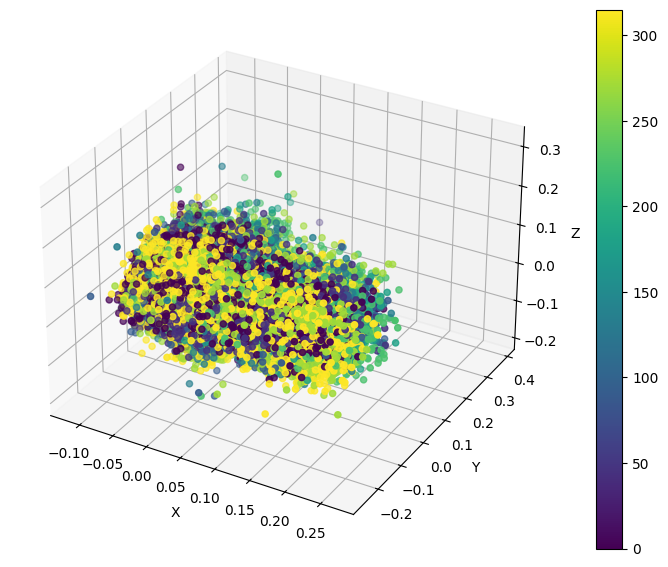

In [54]:
index = 300
autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_{index}.pth"))
autoencoder.eval()
autoencoder.to("cpu")
latent = autoencoder.encoder(torch.tensor(data).float()).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(0, 0, 90)

plt.show()

In [48]:
raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = raw[:, -1]
weights = raw[:, 1:-1]
X,y = get_moons_dataset(1000, 0.1)

weights_0 = weights[angles == 0]
weights_45 = weights[angles == 45]
weights_90 = weights[angles == 90]
weights_135 = weights[angles == 135]
weights_180 = weights[angles == 180]

weights = [weights_0, weights_45, weights_90, weights_135, weights_180]
angles = [0, 45, 90, 135, 180]

autoencoder = Autoencoder()
model = MLP(2, [8], 1)
autoencoder.eval()

accuracies = {}
alpha = 0.5

for i in tqdm(range(0,101,5)):
    autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_{i}.pth"))
    accuracies[i] = []

    for j in range(4):
        for k in range(10000):
            weights_1 = weights[j][k]
            weights_2 = weights[j+1][k]

            latent1 = autoencoder.encoder(torch.tensor(weights_1).float().unsqueeze(0))
            latent2 = autoencoder.encoder(torch.tensor(weights_2).float().unsqueeze(0))

            latent = (1-alpha)*latent1 + alpha*latent2
            output = autoencoder.decoder(latent)
            angle = alpha*angles[j] + (1-alpha)*angles[j+1]
            X_rotated = rotate(X, angle)

            list_to_model(model, output[0].tolist())
            accuracy = get_accuracy(model, X_rotated, y)
            accuracies[i].append(accuracy)


  0%|          | 0/21 [00:00<?, ?it/s]

In [49]:
for key, value in accuracies.items():
    value = np.mean(value)
    print(f"{key}: {value}")

0: 51.3037775
5: 59.21239
10: 63.4823925
15: 65.09878250000001
20: 65.53979749999999
25: 66.7824175
30: 66.22755
35: 66.97749499999999
40: 66.956905
45: 67.3397125
50: 67.541745
55: 67.08979000000001
60: 68.0094175
65: 67.62366499999999
70: 68.60963000000001
75: 68.26346000000001
80: 68.2152725
85: 67.97861999999999
90: 68.151955
95: 68.6269425
100: 68.5327925


## Just checking generalization

In [76]:
class Autoencoder(torch.nn.Module):
    def __init__(self) -> None:
        super(Autoencoder, self).__init__()
        
        self.encoder = self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
        )

        self.decoder = self.decoder = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 33),
        )


    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output


config = {
    "model":{
        "name": "Autoencoder",
        "layers": [33, 512, 1024, 512, 256, 128]
    },
    "hyperparameters":{
        "epochs": 100,
        "learning_rate": 1e-3,
        "weight_decay": 0,
        "optimizer": "Adam",
        "kl_weight": 1
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hyperparameters = config["hyperparameters"]
epochs = hyperparameters["epochs"]
learning_rate = hyperparameters["learning_rate"]
weight_decay = hyperparameters["weight_decay"]
kl_weight = hyperparameters["kl_weight"]


torch.manual_seed(42)

autoencoder = Autoencoder()
autoencoder.to(device)
loss_fn = torch.nn.MSELoss()
latent_loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = torch.device("cuda:0")

dataset = ModelParamsDataset("../data/eight_angles_small.csv", 45)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

In [77]:
autoencoder.train()
autoencoder.to(device)
for i in tqdm(range(101)):
    for X, y in dataloader:
        X = X.to(device)
        output = autoencoder(X)
        loss = loss_fn(output, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if(i % 5 == 0):
        print(f'Epoch: {i+1}, Loss: {loss.item()}')
        torch.save(autoencoder.state_dict(), f"../models/autoencoders/autoencoder_{i}.pth")
    
torch.save(autoencoder.state_dict(), f"../models/autoencoders/autoencoder_final.pth")

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 1, Loss: 2.488947629928589
Epoch: 6, Loss: 0.9477817416191101
Epoch: 11, Loss: 0.4481561481952667
Epoch: 16, Loss: 0.26001396775245667
Epoch: 21, Loss: 0.2074785679578781
Epoch: 26, Loss: 0.16050589084625244
Epoch: 31, Loss: 0.13211020827293396
Epoch: 36, Loss: 0.10470175743103027
Epoch: 41, Loss: 0.09259380400180817
Epoch: 46, Loss: 0.07999373227357864
Epoch: 51, Loss: 0.07895400375127792
Epoch: 56, Loss: 0.06836465746164322
Epoch: 61, Loss: 0.06266950815916061
Epoch: 66, Loss: 0.05211431905627251
Epoch: 71, Loss: 0.04749250039458275
Epoch: 76, Loss: 0.05139071121811867
Epoch: 81, Loss: 0.0485372431576252
Epoch: 86, Loss: 0.04730040580034256
Epoch: 91, Loss: 0.03753722086548805
Epoch: 96, Loss: 0.04152845963835716
Epoch: 101, Loss: 0.05105685070157051


(80000, 128)
(80000, 3)


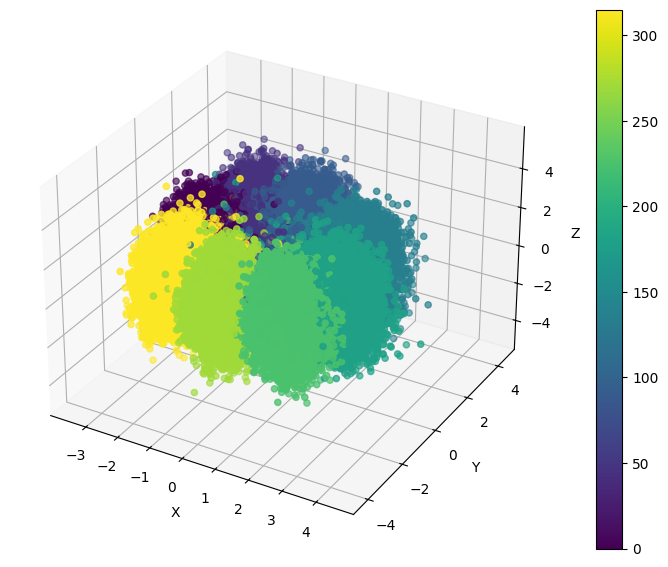

In [79]:
data_raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data_raw[:, -1]
data = data_raw[:, 1:-1]

index = 25
autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_{index}.pth"))
autoencoder.eval()
autoencoder.to("cpu")
latent = autoencoder.encoder(torch.tensor(data).float()).detach().numpy()
print(latent.shape)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent)
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.view_init(0, 0, 90)

plt.show()

In [80]:
raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = raw[:, -1]
weights = raw[:, 1:-1]
X,y = get_moons_dataset(1000, 0.1)

autoencoder = Autoencoder()
model = MLP(2, [8], 1)
autoencoder.eval()

accuracies = {}

for i in tqdm(range(0,101,5)):
    autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_{i}.pth"))
    accuracies[i] = []

    for k in range(80000):
        weights_1 = weights[k]

        output = autoencoder(torch.tensor(weights_1).float().unsqueeze(0))
        X_rotated = rotate(X, angles[k])
        list_to_model(model, output[0].tolist())
        accuracy = get_accuracy(model, X_rotated, y)
        accuracies[i].append(accuracy)

for key, value in accuracies.items():
    value = np.mean(value)
    print(f"{key}: {value}")

  0%|          | 0/21 [00:00<?, ?it/s]

0: 77.9322625
5: 88.6808
10: 93.82182625
15: 95.9449025
20: 97.11584125
25: 97.8639675
30: 98.06779375
35: 98.26808000000001
40: 98.60640250000002
45: 98.85156125
50: 98.92495625
55: 99.00470375
60: 99.1462525
65: 99.2754475
70: 99.3070225
75: 99.36404750000001
80: 99.35993250000001
85: 99.32317874999998
90: 99.46543500000001
95: 99.47649625
100: 99.30194250000001


In [81]:
raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = raw[:, -1]
weights = raw[:, 1:-1]
X,y = get_moons_dataset(1000, 0.1)

weights_0 = weights[angles == 0]
weights_45 = weights[angles == 45]
weights_90 = weights[angles == 90]
weights_135 = weights[angles == 135]
weights_180 = weights[angles == 180]

weights = [weights_0, weights_45, weights_90, weights_135, weights_180]
angles = [0, 45, 90, 135, 180]

autoencoder = Autoencoder()
model = MLP(2, [8], 1)
autoencoder.eval()

accuracies = {}
alpha = 0.5

for i in tqdm(range(0,101,5)):
    autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_{i}.pth"))
    accuracies[i] = []

    for j in range(4):
        for k in range(10000):
            weights_1 = weights[j][k]
            weights_2 = weights[j+1][k]

            latent1 = autoencoder.encoder(torch.tensor(weights_1).float().unsqueeze(0))
            latent2 = autoencoder.encoder(torch.tensor(weights_2).float().unsqueeze(0))

            latent = (1-alpha)*latent1 + alpha*latent2
            output = autoencoder.decoder(latent)
            angle = alpha*angles[j] + (1-alpha)*angles[j+1]
            X_rotated = rotate(X, angle)

            list_to_model(model, output[0].tolist())
            accuracy = get_accuracy(model, X_rotated, y)
            accuracies[i].append(accuracy)

for key, value in accuracies.items():
    value = np.mean(value)
    print(f"{key}: {value}")

  0%|          | 0/21 [00:00<?, ?it/s]

0: 70.806955
5: 86.95934
10: 88.1656875
15: 87.43691000000001
20: 87.9931675
25: 87.92377
30: 87.35504250000001
35: 87.1253925
40: 86.35389
45: 86.6195625
50: 86.015685
55: 85.32499750000001
60: 85.83925999999998
65: 84.94212249999998
70: 84.539165
75: 85.0406975
80: 85.0319625
85: 84.24922000000001
90: 84.41702
95: 83.87316499999999
100: 84.38917250000002


In [82]:
raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = raw[:, -1]
weights = raw[:, 1:-1]
X,y = get_moons_dataset(1000, 0.1)

weights_0 = weights[angles == 0]
weights_45 = weights[angles == 45]
weights_90 = weights[angles == 90]
weights_135 = weights[angles == 135]
weights_180 = weights[angles == 180]

weights = [weights_0, weights_45, weights_90, weights_135, weights_180]
angles = [0, 45, 90, 135, 180]

autoencoder = Autoencoder()
model = MLP(2, [8], 1)
autoencoder.eval()

accuracies = {}
alpha = 0.5

for i in tqdm(range(0,101,5)):
    autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_{i}.pth"))
    accuracies[i] = []

    for j in range(4):
        for k in range(10000):
            weights_1 = weights[j][k]

            latent = autoencoder.encoder(torch.tensor(weights_1).float().unsqueeze(0))

            output = autoencoder.decoder(latent)
            angle = alpha*angles[j] + (1-alpha)*angles[j+1]
            X_rotated = rotate(X, angle)

            list_to_model(model, output[0].tolist())
            accuracy = get_accuracy(model, X_rotated, y)
            accuracies[i].append(accuracy)

for key, value in accuracies.items():
    value = np.mean(value)
    print(f"{key}: {value}")

  0%|          | 0/21 [00:00<?, ?it/s]

0: 71.9008925
5: 90.8681625
10: 94.8602375
15: 96.15825
20: 96.7055475
25: 97.2648375
30: 97.37916499999999
35: 97.56817749999999
40: 97.670925
45: 97.79521500000001
50: 97.802515
55: 97.821995
60: 97.886925
65: 97.97270250000001
70: 98.02663249999999
75: 97.95562000000001
80: 97.99980749999999
85: 98.02935749999999
90: 98.05003500000001
95: 98.07414749999998
100: 97.94669999999999


In [83]:
raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = raw[:, -1]
weights = raw[:, 1:-1]
X,y = get_moons_dataset(1000, 0.1)

weights_0 = weights[angles == 0]
weights_45 = weights[angles == 45]
weights_90 = weights[angles == 90]
weights_135 = weights[angles == 135]
weights_180 = weights[angles == 180]

weights = [weights_0, weights_45, weights_90, weights_135, weights_180]
angles = [0, 45, 90, 135, 180]

autoencoder = Autoencoder()
model = MLP(2, [8], 1)
autoencoder.eval()

accuracies = {}
alpha = 0.5

for i in tqdm(range(0,101,5)):
    autoencoder.load_state_dict(torch.load(f"../models/autoencoders/autoencoder_{i}.pth"))
    accuracies[i] = []

    for j in range(4):
        for k in range(10000):
            weights_2 = weights[j+1][k]

            latent = autoencoder.encoder(torch.tensor(weights_2).float().unsqueeze(0))

            output = autoencoder.decoder(latent)
            angle = alpha*angles[j] + (1-alpha)*angles[j+1]
            X_rotated = rotate(X, angle)

            list_to_model(model, output[0].tolist())
            accuracy = get_accuracy(model, X_rotated, y)
            accuracies[i].append(accuracy)

for key, value in accuracies.items():
    value = np.mean(value)
    print(f"{key}: {value}")

  0%|          | 0/21 [00:00<?, ?it/s]

0: 80.9016125
5: 81.5853825
10: 86.74703000000001
15: 88.77497
20: 91.226375
25: 92.052565
30: 92.0117925
35: 93.03424
40: 92.51132750000001
45: 93.14107000000001
50: 93.30728250000001
55: 93.39036500000002
60: 93.43722
65: 93.58563500000001
70: 93.577125
75: 94.0957975
80: 94.08930249999999
85: 93.508265
90: 94.12429750000001
95: 94.11640499999999
100: 93.98342499999998
